### Building a CNN to classify Skin Melanoma vs Benign

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import numpy as np
import pandas as pd
import cv2 as cv
from google.colab.patches import cv2_imshow
from skimage import io
from PIL import Image
import matplotlib.pylab as plt


In [35]:
import glob
glob.glob("drive/MyDrive/training")


['drive/MyDrive/training']

In [36]:
import os

# The images are in a folder named 'shapes/training'
training_folder_name ='drive/MyDrive/training'

# All images are 128x128 pixels
img_size = (128,128)

# The folder contains a subfolder for each class of shape
classes = sorted(os.listdir(training_folder_name))
print(classes)

['Melanoma', 'Naevus']


### Set up the Framework - initiate Keras

In [37]:
#!pip install --upgrade keras

import sys
import keras
print('Keras version:',keras.__version__)

from keras import backend as K

Keras version: 2.8.0


### Prepare the Data

In [77]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 35

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255, # normalize pixel values
                             validation_split=0.3) # hold back 30% of the images for validation

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    training_folder_name,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    training_folder_name,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data


Getting Data...
Preparing training dataset...
Found 90 images belonging to 2 classes.
Preparing validation dataset...
Found 38 images belonging to 2 classes.


### Define the CNN

In [81]:
# Define a CNN classifier network
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.layers import Activation, Flatten, Dense
from keras import optimizers
import tensorflow as tf 

# Define the model as a sequence of layers
model = Sequential()

# The input layer accepts an image and applies a convolution that uses 32 6x6 filters and a rectified linear unit activation function
model.add(Conv2D(32, (6, 6), input_shape=train_generator.image_shape, activation='relu'))

# Next we'll add a max pooling layer with a 2x2 patch
model.add(MaxPooling2D(pool_size=(2,2)))

# We can add as many layers as we think necessary - here we'll add another convolution layer and another and max poolinglayer
model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Conv2D(32, (6, 6), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

# A dropout layer randomly drops some features to reduce inter-dependencies (which can cause over-fitting)
model.add(Dropout(0.3))

# Now we'll flatten the feature maps and generate an output layer with a predicted probability for each class
model.add(Flatten())
model.add(Dense(train_generator.num_classes, activation='softmax'))

# We'll use the ADAM optimizer
opt = tf.keras.optimizers.Adam(lr=0.001)

# With the layers defined, we can now compile the model for categorical (multi-class) classification
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 123, 123, 32)      3488      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 61, 61, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 56, 56, 32)        36896     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 28, 28, 32)       0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 28, 28, 32)        0         
                                                                 
 flatten_7 (Flatten)         (None, 25088)            

### Train the Model

In [82]:
# Train the model over 5 epochs
num_epochs = 60
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/60
2/2 [==============================] - 6s 4s/step - loss: 0.9327 - accuracy: 0.5273 - val_loss: 0.8470 - val_accuracy: 0.4571
Epoch 2/60
2/2 [==============================] - 5s 3s/step - loss: 0.7873 - accuracy: 0.4571 - val_loss: 0.6573 - val_accuracy: 0.8286
Epoch 3/60
2/2 [==============================] - 5s 3s/step - loss: 0.6692 - accuracy: 0.6182 - val_loss: 0.6810 - val_accuracy: 0.4571
Epoch 4/60
2/2 [==============================] - 4s 2s/step - loss: 0.6461 - accuracy: 0.5818 - val_loss: 0.6583 - val_accuracy: 0.5429
Epoch 5/60
2/2 [==============================] - 5s 3s/step - loss: 0.6187 - accuracy: 0.6545 - val_loss: 0.6326 - val_accuracy: 0.7714
Epoch 6/60
2/2 [==============================] - 5s 3s/step - loss: 0.6395 - accuracy: 0.6143 - val_loss: 0.5890 - val_accuracy: 0.7143
Epoch 7/60
2/2 [==============================] - 4s 3s/step - loss: 0.6457 - accuracy: 0.6182 - val_loss: 0.6770 - val_accuracy: 0.5714
Epoch 8/60
2/2 [=========================

### View the Loss History

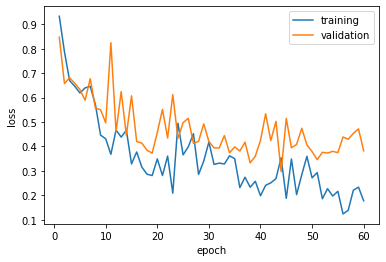

In [83]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### Evaluate the model

In [84]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

print("Generating predictions from validation data...")
# Get the image and label arrays for the first batch of validation data
x_test = validation_generator[0][0]
y_test = validation_generator[0][1]

# Use the moedl to predict the class
class_probabilities = model.predict(x_test)

# The model returns a probability value for each class
# The one with the highest probability is the predicted class
predictions = np.argmax(class_probabilities, axis=1)



Generating predictions from validation data...


In [85]:
predictions

array([0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0])

In [86]:
# The actual labels are hot encoded (e.g. [0 1 0], so get the one with the value 1
true_labels = np.argmax(y_test, axis=1)

In [87]:
true_labels

array([0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0])

In [88]:
import pandas as pd
pd.crosstab(true_labels,predictions)

col_0,0,1
row_0,,
0,14,2
1,2,17


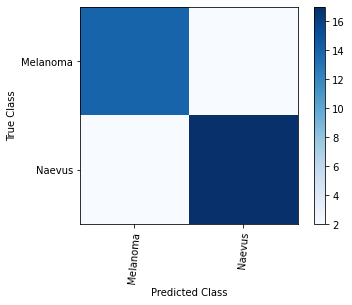

In [89]:


# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=85)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
import pandas as pd
pd.crosstab(true_labels,predictions)
plt.show()

### Save the Model
Now that we have trained the model, we can save it with the trained weights. Then later, we can reload it and use it to predict classes from new images.

In [90]:
from keras.models import load_model

modelFileName = 'melanoma-classifier.h5'

model.save(modelFileName) # saves the trained model
print("Model saved.")

del model  # deletes the existing model variable

Model saved.


## Use the Model with New Data

### Create Functions to Prepare Data and Get Class Predictions
- Resize new images to match the size on which the model was trained.
- Submit the new images to the model and retrieve the predicted classes.

In [91]:
# Helper function to resize image
def resize_image(src_img, size=(128,128), bg_color="white"): 
    from PIL import Image

    # rescale the image so the longest edge is the right size
    src_img.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new image of the right shape
    new_image = Image.new("RGB", size, bg_color)
    
    # Paste the rescaled image onto the new background
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))
  
    # return the resized image
    return new_image

# Function to predict the class of an image
def predict_image(classifier, image_array):
    import numpy as np
    
    # We need to format the input to match the training data
    # The data generator loaded the values as floating point numbers
    # and normalized the pixel values, so...
    img_features = image_array.astype('float32')
    img_features /= 255
    
    # These are the classes our model can predict
    classnames = ['Naevus', 'Melanoma']
    
    # Predict the class of each input image
    predictions = classifier.predict(img_features)
    
    predicted_classes = []
    for prediction in predictions:
        # The prediction for each image is the probability for each class, e.g. [0.8, 0.1, 0.2]
        # So get the index of the highest probability
        class_idx = np.argmax(prediction)
        # And append the corresponding class name to the results
        predicted_classes.append(classnames[int(class_idx)])
    # Return the predictions
    return predicted_classes

print("Functions created - ready to use model for inference.")

Functions created - ready to use model for inference.


### Predict Image Classes

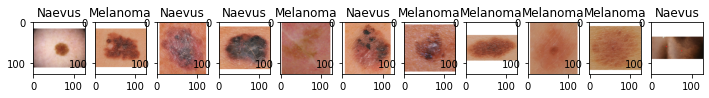

In [92]:
import os
from random import randint
import numpy as np
from PIL import Image
from keras.models import load_model
from matplotlib import pyplot as plt
%matplotlib inline

# load the saved model
modelFileName = 'melanoma-classifier.h5'
model = load_model(modelFileName) 

#get the list of test image files
test_folder = 'drive/MyDrive/Test'
test_image_files = os.listdir(test_folder)

# Empty array on which to store the images
image_arrays = []

size = (128,128)
background_color="white"

fig = plt.figure(figsize=(12, 8))


# Get the images and show the predicted classes
for file_idx in range(len(test_image_files)):
    img = Image.open(os.path.join(test_folder, test_image_files[file_idx]))
    
    # resize the image so it matches the training set - it  must be the same size as the images on which the model was trained
    resized_img = np.array(resize_image(img, size, background_color))
                      
    # Add the image to the array of images
    image_arrays.append(resized_img)
    

# Get predictions from the array of image arrays
# Note that the model expects an array of 1 or more images - just like the batches on which it was trained
predictions = predict_image(model, np.array(image_arrays))

# plot easch image with its corresponding prediction
for idx in range(len(predictions)):
    a=fig.add_subplot(1,len(predictions),idx+1)
    imgplot = plt.imshow(image_arrays[idx])
    a.set_title(predictions[idx])
    